In [1]:
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
import matplotlib.pyplot as plt
import time as t

In [2]:
# function to load pickle files
def load_pickle_file(pickle_file, dataset_str, labels_str):
    with open(pickle_file, 'rb') as f:
        save = pickle.load(f)
        dataset = save[dataset_str]
        labels = save[labels_str]
        del save
    return dataset, labels

pkl_train = 'svhn_my_all_color_train.pickle'
pkl_test = 'svhn_my_all_color_test.pickle'
pkl_valid = 'svhn_my_all_color_valid.pickle'
train_dataset, train_labels = load_pickle_file(pkl_train, 'train_dataset', 'train_labels')
test_dataset, test_labels = load_pickle_file(pkl_test, 'test_dataset', 'test_labels')
valid_dataset, valid_labels = load_pickle_file(pkl_valid, 'valid_dataset', 'valid_labels')

print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (229754, 32, 32, 3) (229754, 6)
Validation set (6000, 32, 32, 3) (6000, 6)
Test set (13068, 32, 32, 3) (13068, 6)


In [3]:
# define accuracy as performance metric to be used in this exercise
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 2).T == labels) / predictions.shape[1] / predictions.shape[0])

In [6]:
print(test_dataset.shape)
test_dataset_0=test_dataset[0:6534,:,:,:]
test_dataset_1=test_dataset[6534:13068,:,:,:]
#test_dataset_2=test_dataset[9000:,:,:,:]
print(test_dataset_0.shape)
print(test_dataset_1.shape)

(13068, 32, 32, 3)
(6534, 32, 32, 3)
(6534, 32, 32, 3)


[ 2  2  6 10 10 10]


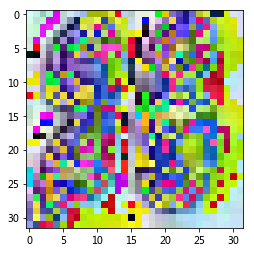

In [5]:
%matplotlib inline
img_test=train_dataset[10]
plt.imshow(img_test)
print(train_labels[10])

# base_model

In [4]:
height = 32
width = 32
channels = 3
n_inputs = height * width
conv1_fmaps = 32
conv1_ksize = 3
conv1_stride = 1
conv1_pad = "SAME"
conv2_fmaps = 64
conv2_ksize = 3
conv2_stride = 2
conv2_pad = "SAME"
pool3_fmaps = conv2_fmaps
n_fc1 = 64
n_outputs = 11

In [11]:

tf.reset_default_graph() 
with tf.name_scope("inputs1"):
    X = tf.placeholder(tf.float32, shape=[None,height, width, channels], name="X")
    #X_reshaped = tf.reshape(X, shape=[-1, ])
    y = tf.placeholder(tf.int32, shape=[None,6], name="y")

conv1 = tf.layers.conv2d(X, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding=conv1_pad,
                         activation=tf.nn.relu, name="conv1")
conv2 = tf.layers.conv2d(conv1, filters=conv2_fmaps, kernel_size=conv2_ksize,
                         strides=conv2_stride, padding=conv2_pad,
                         activation=tf.nn.relu, name="conv2")

with tf.name_scope("pool3"):
    pool3 = tf.layers.max_pooling2d(conv2, 2,2, padding="VALID")
    pool3_flat = tf.reshape(pool3, shape=[-1, pool3_fmaps * 8 * 8])

with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool3_flat, n_fc1, activation=tf.nn.relu, name="fc1")

with tf.name_scope("output"):
    logits1 = tf.layers.dense(fc1, n_outputs, name="output1")
    logits2 = tf.layers.dense(fc1, n_outputs, name="output2")
    logits3 = tf.layers.dense(fc1, n_outputs, name="output3")
    logits4 = tf.layers.dense(fc1, n_outputs, name="output4")
    logits5 = tf.layers.dense(fc1, n_outputs, name="output5")


with tf.name_scope("train"):
    loss1 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits1, labels=y[:,1]))
    loss2 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits2, labels=y[:,2]))
    loss3 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits3, labels=y[:,3]))
    loss4 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits4, labels=y[:,4]))
    loss5 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits5, labels=y[:,5]))
    loss = loss1+loss2+loss3+loss4+loss5
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    predictions = tf.stack([tf.nn.softmax(logits1),\
                                tf.nn.softmax(logits2),\
                                tf.nn.softmax(logits3),\
                                tf.nn.softmax(logits4),\
                                tf.nn.softmax(logits5)])
    
with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

In [12]:
n_epochs = 10
batch_size = 64

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(len(train_dataset)// batch_size):
            offset = (iteration * batch_size) % (train_labels.shape[0] - batch_size)
            X_batch = train_dataset[offset:(offset + batch_size), :, :, :]
            y_batch = train_labels[offset:(offset + batch_size),:]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            if iteration %500 ==0:
                train_pre = predictions.eval(feed_dict={X:X_batch})
                #print(type(train_pre))
                val_pre = predictions.eval(feed_dict={X:valid_dataset})     
                #print(type(val_pre))
                acc_val = accuracy(val_pre, valid_labels[:,1:6])
                acc_train = accuracy(train_pre,y_batch[:,1:6])
                print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_val)

        save_path = saver.save(sess, ".ipynb_checkpoints/2.ckpt")

0 Train accuracy: 42.8125 Test accuracy: 43.4433333333
0 Train accuracy: 80.9375 Test accuracy: 77.9566666667
0 Train accuracy: 79.375 Test accuracy: 82.27
0 Train accuracy: 85.625 Test accuracy: 84.3966666667
0 Train accuracy: 90.625 Test accuracy: 85.3633333333
0 Train accuracy: 88.125 Test accuracy: 86.67
0 Train accuracy: 88.75 Test accuracy: 87.24
0 Train accuracy: 89.0625 Test accuracy: 87.7
1 Train accuracy: 90.3125 Test accuracy: 87.8266666667
1 Train accuracy: 92.5 Test accuracy: 87.97
1 Train accuracy: 88.125 Test accuracy: 88.6166666667
1 Train accuracy: 89.0625 Test accuracy: 88.5933333333
1 Train accuracy: 93.125 Test accuracy: 88.9866666667
1 Train accuracy: 90.3125 Test accuracy: 89.1
1 Train accuracy: 88.125 Test accuracy: 89.4033333333
1 Train accuracy: 88.75 Test accuracy: 89.4333333333
2 Train accuracy: 90.625 Test accuracy: 89.5966666667
2 Train accuracy: 93.75 Test accuracy: 89.51
2 Train accuracy: 88.125 Test accuracy: 89.6566666667
2 Train accuracy: 91.25 Test ac

In [14]:
# test use a singe example
with tf.Session() as sess:
    saver.restore(sess,".ipynb_checkpoints/2.ckpt" )
    pre = np.argmax(predictions.eval(feed_dict={X:train_dataset[999:1000]}),2)
    print(pre,train_labels[999,1:6])

INFO:tensorflow:Restoring parameters from .ipynb_checkpoints/2.ckpt
[[ 3]
 [ 1]
 [ 5]
 [10]
 [10]] [ 3  1  5 10 10]


#  try to add a conv and pool layer

In [38]:
tf.reset_default_graph() 
graph = tf.Graph()

with graph.as_default():
    X = tf.placeholder(tf.float32, shape=[None,height, width, channels], name="X")
    #X_reshaped = tf.reshape(X, shape=[-1, ])
    y = tf.placeholder(tf.int32, shape=[None,6], name="y")
    conv1 = tf.layers.conv2d(X, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding=conv1_pad,
                         activation=tf.nn.relu, name="conv1")
    pool1 = tf.layers.max_pooling2d(conv1,pool_size=2,strides=2,padding='same')
    conv2 = tf.layers.conv2d(pool1, filters=conv2_fmaps, kernel_size=conv2_ksize,
                         strides=conv2_stride, padding=conv2_pad,
                         activation=tf.nn.relu, name="conv2")
    pool2 = tf.layers.max_pooling2d(conv2,pool_size=2,strides=2,padding='same')
    conv3 = tf.layers.conv2d(pool2,filters=128,kernel_size=conv2_ksize,
                        strides=conv2_stride,padding=conv2_pad)
    pool3 = tf.layers.max_pooling2d(conv3, 2,2, padding="same")
    pool3_flat = tf.layers.flatten(pool3)
    fc1 = tf.layers.dense(pool3_flat, n_fc1, activation=tf.nn.relu, name="fc1")
    logits1 = tf.layers.dense(fc1, n_outputs, name="output1")
    logits2 = tf.layers.dense(fc1, n_outputs, name="output2")
    logits3 = tf.layers.dense(fc1, n_outputs, name="output3")
    logits4 = tf.layers.dense(fc1, n_outputs, name="output4")
    logits5 = tf.layers.dense(fc1, n_outputs, name="output5")
    loss1 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits1, labels=y[:,1]))
    loss2 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits2, labels=y[:,2]))
    loss3 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits3, labels=y[:,3]))
    loss4 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits4, labels=y[:,4]))
    loss5 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits5, labels=y[:,5]))
    loss = loss1+loss2+loss3+loss4+loss5
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)
    predictions = tf.stack([tf.nn.softmax(logits1),\
                                tf.nn.softmax(logits2),\
                                tf.nn.softmax(logits3),\
                                tf.nn.softmax(logits4),\
                                tf.nn.softmax(logits5)])

    init = tf.global_variables_initializer()
    saver = tf.train.Saver()


In [40]:
n_epochs = 10
batch_size = 64

with tf.Session(graph=graph) as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(len(train_dataset)// batch_size):
            offset = (iteration * batch_size) % (train_labels.shape[0] - batch_size)
            X_batch = train_dataset[offset:(offset + batch_size), :, :, :]
            y_batch = train_labels[offset:(offset + batch_size),:]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            if iteration %500 ==0:
                train_pre = predictions.eval(feed_dict={X:X_batch})
                #print(type(train_pre))
                val_pre = predictions.eval(feed_dict={X:valid_dataset})     
                #print(type(val_pre))
                acc_val = accuracy(val_pre, valid_labels[:,1:6])
                acc_train = accuracy(train_pre,y_batch[:,1:6])
                print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_val)

        save_path = saver.save(sess, ".ipynb_checkpoints/3.ckpt")

0 Train accuracy: 39.375 Test accuracy: 36.13
0 Train accuracy: 76.5625 Test accuracy: 77.7633333333
0 Train accuracy: 81.25 Test accuracy: 84.1733333333
0 Train accuracy: 88.125 Test accuracy: 87.2
0 Train accuracy: 90.625 Test accuracy: 88.1466666667
0 Train accuracy: 92.8125 Test accuracy: 89.6633333333
0 Train accuracy: 91.25 Test accuracy: 89.9066666667
0 Train accuracy: 89.375 Test accuracy: 90.6366666667
1 Train accuracy: 93.125 Test accuracy: 91.2266666667
1 Train accuracy: 95.0 Test accuracy: 91.4833333333
1 Train accuracy: 89.6875 Test accuracy: 91.8066666667
1 Train accuracy: 93.125 Test accuracy: 92.25
1 Train accuracy: 95.625 Test accuracy: 92.2433333333
1 Train accuracy: 95.9375 Test accuracy: 92.7
1 Train accuracy: 91.25 Test accuracy: 92.8
1 Train accuracy: 91.875 Test accuracy: 92.9233333333
2 Train accuracy: 92.8125 Test accuracy: 92.9366666667
2 Train accuracy: 95.9375 Test accuracy: 93.0733333333
2 Train accuracy: 91.875 Test accuracy: 93.29
2 Train accuracy: 94.062

In [43]:
with tf.Session(graph=graph) as sess:
    saver.restore(sess,".ipynb_checkpoints/3.ckpt" )
    test_prediction = sess.run(predictions, feed_dict={X:test_dataset})
    acc = accuracy(test_prediction,test_labels[:,1:6])  
    print(acc)

INFO:tensorflow:Restoring parameters from .ipynb_checkpoints/3.ckpt
93.6715641261


# let's add layer

In [98]:
tf.reset_default_graph() 
mygraph1 = tf.Graph()

with mygraph1.as_default():
    X = tf.placeholder(tf.float32, shape=[None,height, width, channels], name="X")
    #X_reshaped = tf.reshape(X, shape=[-1, ])
    y = tf.placeholder(tf.int32, shape=[None,6], name="y")

    he_init = tf.contrib.layers.variance_scaling_initializer()
    conv1 = tf.layers.conv2d(X, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding=conv1_pad,
                         activation=tf.nn.relu, name="conv1")
    pool1 = tf.layers.max_pooling2d(conv1,pool_size=2,strides=2,padding='same')
    conv2 = tf.layers.conv2d(pool1, filters=conv2_fmaps, kernel_size=conv2_ksize,
                         strides=conv2_stride, padding=conv2_pad,
                         activation=tf.nn.relu, name="conv2")
    pool2 = tf.layers.max_pooling2d(conv2,pool_size=2,strides=2,padding='same')
    conv3 = tf.layers.conv2d(pool2,filters=128,kernel_size=conv2_ksize,
                        strides=conv2_stride,padding=conv2_pad)
    pool3 = tf.layers.max_pooling2d(conv3, 2,2, padding="same")

    conv4 = tf.layers.conv2d(pool3,filters=256,kernel_size=conv2_ksize,
                        strides=conv2_stride,padding=conv2_pad)
    pool4 = tf.layers.max_pooling2d(conv4, 2,2, padding="same")
    pool4_flat = tf.layers.flatten(pool4)
    fc1 = tf.layers.dense(pool4_flat, n_fc1, activation=tf.nn.relu, name="fc1")
    
    logits1 = tf.layers.dense(fc1, n_outputs, name="output1")
    logits2 = tf.layers.dense(fc1, n_outputs, name="output2")
    logits3 = tf.layers.dense(fc1, n_outputs, name="output3")
    logits4 = tf.layers.dense(fc1, n_outputs, name="output4")
    logits5 = tf.layers.dense(fc1, n_outputs, name="output5")
    loss1 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits1, labels=y[:,1]))
    loss2 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits2, labels=y[:,2]))
    loss3 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits3, labels=y[:,3]))
    loss4 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits4, labels=y[:,4]))
    loss5 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits5, labels=y[:,5]))
    loss = loss1+loss2+loss3+loss4+loss5
    global_step = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(0.05, global_step, 10000, 0.95)
    training_op = tf.train.AdagradOptimizer(learning_rate).minimize(loss, global_step=global_step)
    #optimizer = tf.train.AdamOptimizer(learning_rate=5e-4)
    #training_op = optimizer.minimize(loss)
    predictions = tf.stack([tf.nn.softmax(logits1),\
                                tf.nn.softmax(logits2),\
                                tf.nn.softmax(logits3),\
                                tf.nn.softmax(logits4),\
                                tf.nn.softmax(logits5)])

    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

In [99]:
n_epochs = 6
batch_size = 64
myloss=0.0
with tf.Session(graph=mygraph1) as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(len(train_dataset)// batch_size):
            offset = (iteration * batch_size) % (train_labels.shape[0] - batch_size)
            X_batch = train_dataset[offset:(offset + batch_size), :, :, :]
            y_batch = train_labels[offset:(offset + batch_size),:]
            sess.run([training_op], feed_dict={X: X_batch, y: y_batch})
            
            if iteration %500 ==0:
                train_pre = predictions.eval(feed_dict={X:X_batch})
                #print(type(train_pre))
                val_pre = predictions.eval(feed_dict={X:valid_dataset})     
                #print(type(val_pre))
                acc_val = accuracy(val_pre, valid_labels[:,1:6])
                acc_train = accuracy(train_pre,y_batch[:,1:6])
                myloss = loss1.eval(feed_dict={X: X_batch, y: y_batch})
                print(epoch, "Train accuracy:", acc_train, "val accuracy:", acc_val,"loss",myloss)

        save_path = saver.save(sess, ".ipynb_checkpoints/3.ckpt")
    test_prediction = sess.run(predictions, feed_dict={X:test_dataset})
    acc_test = accuracy(test_prediction,test_labels[:,1:6])  
    print('acc_test',acc_test)

0 Train accuracy: 33.125 val accuracy: 31.33 loss 2.27038
0 Train accuracy: 78.75 val accuracy: 73.75 loss 0.734038
0 Train accuracy: 87.8125 val accuracy: 84.3533333333 loss 0.374085
0 Train accuracy: 95.3125 val accuracy: 88.26 loss 0.188541
0 Train accuracy: 96.875 val accuracy: 89.5833333333 loss 0.243734
0 Train accuracy: 97.5 val accuracy: 91.0533333333 loss 0.101325
0 Train accuracy: 96.25 val accuracy: 91.6366666667 loss 0.200216
0 Train accuracy: 95.9375 val accuracy: 91.5866666667 loss 0.186325
1 Train accuracy: 96.875 val accuracy: 92.2566666667 loss 0.140618
1 Train accuracy: 98.4375 val accuracy: 92.5866666667 loss 0.0843248
1 Train accuracy: 95.9375 val accuracy: 92.81 loss 0.224882
1 Train accuracy: 97.1875 val accuracy: 93.04 loss 0.157401
1 Train accuracy: 99.375 val accuracy: 93.0133333333 loss 0.13217
1 Train accuracy: 98.4375 val accuracy: 93.4633333333 loss 0.0677942
1 Train accuracy: 97.8125 val accuracy: 93.6166666667 loss 0.181758
1 Train accuracy: 97.8125 val a

In [100]:
# that's add a drop out 

In [108]:
tf.reset_default_graph() 
mygraph1 = tf.Graph()

with mygraph1.as_default():
    X = tf.placeholder(tf.float32, shape=[None,height, width, channels], name="X")
    #X_reshaped = tf.reshape(X, shape=[-1, ])
    y = tf.placeholder(tf.int32, shape=[None,6], name="y")
    training = tf.placeholder_with_default(False, shape=[], name='training')
    he_init = tf.contrib.layers.variance_scaling_initializer()
    conv1 = tf.layers.conv2d(X, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding=conv1_pad,
                         activation=tf.nn.relu, name="conv1")
    pool1 = tf.layers.max_pooling2d(conv1,pool_size=2,strides=2,padding='same')
    conv2 = tf.layers.conv2d(pool1, filters=conv2_fmaps, kernel_size=conv2_ksize,
                         strides=conv2_stride, padding=conv2_pad,
                         activation=tf.nn.relu, name="conv2")
    pool2 = tf.layers.max_pooling2d(conv2,pool_size=2,strides=2,padding='same')
    conv3 = tf.layers.conv2d(pool2,filters=128,kernel_size=conv2_ksize,
                        strides=conv2_stride,padding=conv2_pad)
    pool3 = tf.layers.max_pooling2d(conv3, 2,2, padding="same")

    conv4 = tf.layers.conv2d(pool3,filters=256,kernel_size=conv2_ksize,
                        strides=conv2_stride,padding=conv2_pad,activation=tf.nn.relu)
    pool4 = tf.layers.max_pooling2d(conv4, 2,2, padding="same")
    pool4_flat = tf.layers.flatten(pool4)
   # pool4_flat = tf.layers.dropout(pool4_flat, training=training)
    fc1 = tf.layers.dense(pool4_flat, n_fc1, activation=tf.nn.relu, name="fc1")
    fc1 = tf.layers.dropout(fc1, training=training)
    logits1 = tf.layers.dense(fc1, n_outputs, name="output1")
    logits2 = tf.layers.dense(fc1, n_outputs, name="output2")
    logits3 = tf.layers.dense(fc1, n_outputs, name="output3")
    logits4 = tf.layers.dense(fc1, n_outputs, name="output4")
    logits5 = tf.layers.dense(fc1, n_outputs, name="output5")
    loss1 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits1, labels=y[:,1]))
    loss2 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits2, labels=y[:,2]))
    loss3 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits3, labels=y[:,3]))
    loss4 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits4, labels=y[:,4]))
    loss5 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits5, labels=y[:,5]))
    loss = loss1+loss2+loss3+loss4+loss5
    global_step = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(0.05, global_step, 10000, 0.95)
    training_op = tf.train.AdagradOptimizer(learning_rate).minimize(loss, global_step=global_step)
    #optimizer = tf.train.AdamOptimizer(learning_rate=5e-4)
    #training_op = optimizer.minimize(loss)
    predictions = tf.stack([tf.nn.softmax(logits1),\
                                tf.nn.softmax(logits2),\
                                tf.nn.softmax(logits3),\
                                tf.nn.softmax(logits4),\
                                tf.nn.softmax(logits5)])

    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

In [109]:
n_epochs = 6
batch_size = 64
myloss=0.0
with tf.Session(graph=mygraph1) as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(len(train_dataset)// batch_size):
            offset = (iteration * batch_size) % (train_labels.shape[0] - batch_size)
            X_batch = train_dataset[offset:(offset + batch_size), :, :, :]
            y_batch = train_labels[offset:(offset + batch_size),:]
            sess.run([training_op], feed_dict={X: X_batch, y: y_batch, training:True})
            
            if iteration %500 ==0:
                train_pre = predictions.eval(feed_dict={X:X_batch})
                #print(type(train_pre))
                val_pre = predictions.eval(feed_dict={X:valid_dataset})     
                #print(type(val_pre))
                acc_val = accuracy(val_pre, valid_labels[:,1:6])
                acc_train = accuracy(train_pre,y_batch[:,1:6])
                myloss = loss1.eval(feed_dict={X: X_batch, y: y_batch})
                print(epoch, "Train accuracy:", acc_train, "val accuracy:", acc_val,"loss",myloss)

        save_path = saver.save(sess, ".ipynb_checkpoints/3.ckpt")
    test_prediction = sess.run(predictions, feed_dict={X:test_dataset})
    acc_test = accuracy(test_prediction,test_labels[:,1:6])  
    print('acc_test',acc_test)

0 Train accuracy: 51.25 val accuracy: 50.5666666667 loss 2.38419
0 Train accuracy: 66.25 val accuracy: 61.7566666667 loss 1.47546
0 Train accuracy: 77.1875 val accuracy: 75.71 loss 0.757426
0 Train accuracy: 86.5625 val accuracy: 81.6266666667 loss 0.512815
0 Train accuracy: 91.5625 val accuracy: 84.6966666667 loss 0.494119
0 Train accuracy: 89.0625 val accuracy: 86.82 loss 0.384874
0 Train accuracy: 90.3125 val accuracy: 87.9633333333 loss 0.383948
0 Train accuracy: 89.6875 val accuracy: 88.9166666667 loss 0.313967
1 Train accuracy: 91.875 val accuracy: 88.9166666667 loss 0.226047
1 Train accuracy: 93.75 val accuracy: 89.5166666667 loss 0.157038
1 Train accuracy: 88.4375 val accuracy: 90.34 loss 0.419954
1 Train accuracy: 95.3125 val accuracy: 90.4033333333 loss 0.17741
1 Train accuracy: 94.0625 val accuracy: 90.9533333333 loss 0.27696
1 Train accuracy: 93.75 val accuracy: 91.28 loss 0.149484
1 Train accuracy: 94.6875 val accuracy: 91.68 loss 0.247669
1 Train accuracy: 92.5 val accura

In [ ]:
# add local norm

In [129]:
# tf.reset_default_graph() 
mygraph1 = tf.Graph()

with mygraph1.as_default():
    X = tf.placeholder(tf.float32, shape=[None,height, width, channels], name="X")
    #X_reshaped = tf.reshape(X, shape=[-1, ])
    y = tf.placeholder(tf.int32, shape=[None,6], name="y")
    training = tf.placeholder_with_default(False, shape=[], name='training')
    he_init = tf.contrib.layers.variance_scaling_initializer()
    conv1 = tf.layers.conv2d(X, filters=32, kernel_size=5,strides=1,activation=tf.nn.relu)              
    conv1 = tf.nn.local_response_normalization(conv1)
    pool1 = tf.layers.max_pooling2d(conv1,pool_size=2,strides=2,padding='same')
    conv2 = tf.layers.conv2d(pool1, filters=64, kernel_size=5,strides=1,activation=tf.nn.relu)
    conv2 = tf.nn.local_response_normalization(conv2)
    pool2 = tf.layers.max_pooling2d(conv2,pool_size=2,strides=2,padding='same')
    conv3 = tf.layers.conv2d(pool2,filters=512,kernel_size=5,strides=1,activation=tf.nn.relu)
    conv3 = tf.nn.local_response_normalization(conv3)
   
    pool4_flat = tf.layers.dropout(conv3, rate=0.75,training=training)    
    pool4_flat = tf.layers.flatten(pool4_flat)
    
    fc1 = tf.layers.dense(pool4_flat, 256, activation=tf.nn.relu)
    fc1 = tf.layers.dropout(fc1,  rate=0.75,training=training)
    logits1 = tf.layers.dense(fc1, n_outputs, name="output1")
    logits2 = tf.layers.dense(fc1, n_outputs, name="output2")
    logits3 = tf.layers.dense(fc1, n_outputs, name="output3")
    logits4 = tf.layers.dense(fc1, n_outputs, name="output4")
    logits5 = tf.layers.dense(fc1, n_outputs, name="output5")
    loss1 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits1, labels=y[:,1]))
    loss2 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits2, labels=y[:,2]))
    loss3 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits3, labels=y[:,3]))
    loss4 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits4, labels=y[:,4]))
    loss5 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits5, labels=y[:,5]))
    loss = loss1+loss2+loss3+loss4+loss5
    global_step = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(0.05, global_step, 10000, 0.95)
    training_op = tf.train.AdagradOptimizer(learning_rate).minimize(loss, global_step=global_step)
    #optimizer = tf.train.AdamOptimizer(learning_rate=5e-4)
    #training_op = optimizer.minimize(loss)
    predictions = tf.stack([tf.nn.softmax(logits1),\
                                tf.nn.softmax(logits2),\
                                tf.nn.softmax(logits3),\
                                tf.nn.softmax(logits4),\
                                tf.nn.softmax(logits5)])

    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

In [130]:
n_epochs = 10
batch_size = 64
myloss=0.0
with tf.Session(graph=mygraph1) as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(len(train_dataset)// batch_size):
            offset = (iteration * batch_size) % (train_labels.shape[0] - batch_size)
            X_batch = train_dataset[offset:(offset + batch_size), :, :, :]
            y_batch = train_labels[offset:(offset + batch_size),:]
            sess.run([training_op], feed_dict={X: X_batch, y: y_batch, training:True})
            
            if iteration %500 ==0:
                train_pre = predictions.eval(feed_dict={X:X_batch})
                #print(type(train_pre))
                val_pre = predictions.eval(feed_dict={X:valid_dataset})     
                #print(type(val_pre))
                acc_val = accuracy(val_pre, valid_labels[:,1:6])
                acc_train = accuracy(train_pre,y_batch[:,1:6])
                myloss = loss1.eval(feed_dict={X: X_batch, y: y_batch})
                print(epoch, "Train accuracy:", acc_train, "val accuracy:", acc_val,"loss",myloss)

        save_path = saver.save(sess, ".ipynb_checkpoints/4.ckpt")
    test_prediction = sess.run(predictions, feed_dict={X:test_dataset})
    acc_test = accuracy(test_prediction,test_labels[:,1:6])  
    print('acc_test',acc_test)

0 Train accuracy: 54.6875 val accuracy: 52.12 loss 2.30427
0 Train accuracy: 63.75 val accuracy: 63.9033333333 loss 1.44722
0 Train accuracy: 73.4375 val accuracy: 73.9133333333 loss 0.958066
0 Train accuracy: 81.25 val accuracy: 78.5033333333 loss 0.737397
0 Train accuracy: 87.8125 val accuracy: 81.4433333333 loss 0.662165
0 Train accuracy: 84.0625 val accuracy: 82.6066666667 loss 0.70383
0 Train accuracy: 89.0625 val accuracy: 84.8633333333 loss 0.656467
0 Train accuracy: 86.25 val accuracy: 86.5266666667 loss 0.582105
1 Train accuracy: 86.875 val accuracy: 86.47 loss 0.523575
1 Train accuracy: 92.5 val accuracy: 87.9666666667 loss 0.430324
1 Train accuracy: 87.1875 val accuracy: 88.6366666667 loss 0.614644
1 Train accuracy: 90.0 val accuracy: 89.22 loss 0.375707
1 Train accuracy: 95.0 val accuracy: 89.8566666667 loss 0.324665
1 Train accuracy: 91.25 val accuracy: 90.3533333333 loss 0.390957
1 Train accuracy: 92.8125 val accuracy: 90.6733333333 loss 0.390859
1 Train accuracy: 91.5625

In [137]:
# tf.reset_default_graph() 
mygraph1 = tf.Graph()

with mygraph1.as_default():
    X = tf.placeholder(tf.float32, shape=[None,height, width, channels], name="X")
    #X_reshaped = tf.reshape(X, shape=[-1, ])
    y = tf.placeholder(tf.int32, shape=[None,6], name="y")
    training = tf.placeholder_with_default(False, shape=[], name='training')
    he_init = tf.contrib.layers.variance_scaling_initializer()
    conv1 = tf.layers.conv2d(X, filters=32, kernel_size=5,strides=1,activation=tf.nn.relu)              
    conv1 = tf.nn.local_response_normalization(conv1)
    pool1 = tf.layers.max_pooling2d(conv1,pool_size=2,strides=2,padding='same')
    conv2 = tf.layers.conv2d(pool1, filters=64, kernel_size=5,strides=1,activation=tf.nn.relu)
    conv2 = tf.nn.local_response_normalization(conv2)
    pool2 = tf.layers.max_pooling2d(conv2,pool_size=2,strides=2,padding='same')
    conv3 = tf.layers.conv2d(pool2,filters=512,kernel_size=5,strides=1,activation=tf.nn.relu)
    conv3 = tf.nn.local_response_normalization(conv3)
   
    #pool4_flat = tf.layers.dropout(conv3, rate=0.75,training=training)    
    pool4_flat = tf.layers.flatten(conv3)
    
    fc1 = tf.layers.dense(pool4_flat, 256, activation=tf.nn.relu)
    #fc1 = tf.layers.dropout(fc1,  rate=0.75,training=training)
    logits1 = tf.layers.dense(fc1, n_outputs, name="output1")
    logits2 = tf.layers.dense(fc1, n_outputs, name="output2")
    logits3 = tf.layers.dense(fc1, n_outputs, name="output3")
    logits4 = tf.layers.dense(fc1, n_outputs, name="output4")
    logits5 = tf.layers.dense(fc1, n_outputs, name="output5")
    loss1 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits1, labels=y[:,1]))
    loss2 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits2, labels=y[:,2]))
    loss3 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits3, labels=y[:,3]))
    loss4 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits4, labels=y[:,4]))
    loss5 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits5, labels=y[:,5]))
    loss = loss1+loss2+loss3+loss4+loss5
    global_step = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(0.1, global_step, 10000, 0.95)
    training_op = tf.train.AdagradOptimizer(learning_rate).minimize(loss, global_step=global_step)
    #optimizer = tf.train.AdamOptimizer(learning_rate=5e-4)
    #training_op = optimizer.minimize(loss)
    predictions = tf.stack([tf.nn.softmax(logits1),\
                                tf.nn.softmax(logits2),\
                                tf.nn.softmax(logits3),\
                                tf.nn.softmax(logits4),\
                                tf.nn.softmax(logits5)])

    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

In [138]:
n_epochs = 15
batch_size = 128
myloss=0.0
with tf.Session(graph=mygraph1) as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(len(train_dataset)// batch_size):
            offset = (iteration * batch_size) % (train_labels.shape[0] - batch_size)
            X_batch = train_dataset[offset:(offset + batch_size), :, :, :]
            y_batch = train_labels[offset:(offset + batch_size),:]
            sess.run([training_op], feed_dict={X: X_batch, y: y_batch, training:True})
            
            if iteration %500 ==0:
                train_pre = predictions.eval(feed_dict={X:X_batch})
                #print(type(train_pre))
                val_pre = predictions.eval(feed_dict={X:valid_dataset})     
                #print(type(val_pre))
                acc_val = accuracy(val_pre, valid_labels[:,1:6])
                acc_train = accuracy(train_pre,y_batch[:,1:6])
                myloss = loss1.eval(feed_dict={X: X_batch, y: y_batch})
                print(epoch, "Train accuracy:", acc_train, "val accuracy:", acc_val,"loss",myloss)

        save_path = saver.save(sess, ".ipynb_checkpoints/4.ckpt")
    test_prediction = sess.run(predictions, feed_dict={X:test_dataset})
    acc_test = accuracy(test_prediction,test_labels[:,1:6])  
    print('acc_test',acc_test)

0 Train accuracy: 52.96875 val accuracy: 51.77 loss 2.25889
0 Train accuracy: 89.6875 val accuracy: 84.4833333333 loss 0.496126
0 Train accuracy: 96.5625 val accuracy: 91.2133333333 loss 0.15096
0 Train accuracy: 97.96875 val accuracy: 93.6666666667 loss 0.081123
1 Train accuracy: 99.0625 val accuracy: 94.3633333333 loss 0.035641
1 Train accuracy: 98.59375 val accuracy: 94.89 loss 0.100151
1 Train accuracy: 99.53125 val accuracy: 95.2766666667 loss 0.0638814
1 Train accuracy: 99.6875 val accuracy: 95.78 loss 0.0449799
2 Train accuracy: 99.53125 val accuracy: 95.7833333333 loss 0.0166259
2 Train accuracy: 99.375 val accuracy: 95.92 loss 0.0471061
2 Train accuracy: 99.6875 val accuracy: 95.9566666667 loss 0.0439
2 Train accuracy: 99.6875 val accuracy: 96.22 loss 0.0255076
3 Train accuracy: 100.0 val accuracy: 96.1266666667 loss 0.0109989
3 Train accuracy: 99.6875 val accuracy: 96.26 loss 0.0310912
3 Train accuracy: 99.84375 val accuracy: 96.2366666667 loss 0.0282972
3 Train accuracy: 99.

In [ ]:
#overfiting  when add batch norm,it will decrease the acc,so drop the batch_norm

In [144]:
n_epochs = 6
batch_size = 100
myloss=0.0
best_acc =0.0
n=10
with tf.Session(graph=mygraph1) as sess:
    init.run()
    for epoch in range(n_epochs):
        if n==0:
            break
        for iteration in range(len(train_dataset)// batch_size):
            if n==0:
                break
            offset = (iteration * batch_size) % (train_labels.shape[0] - batch_size)
            X_batch = train_dataset[offset:(offset + batch_size), :, :, :]
            y_batch = train_labels[offset:(offset + batch_size),:]
            sess.run([training_op], feed_dict={X: X_batch, y: y_batch, training:True})
            
            if iteration %500 ==0:
                train_pre = predictions.eval(feed_dict={X:X_batch})
                #print(type(train_pre))
                val_pre = predictions.eval(feed_dict={X:valid_dataset})     
                #print(type(val_pre))
                acc_val = accuracy(val_pre, valid_labels[:,1:6])
                acc_train = accuracy(train_pre,y_batch[:,1:6])
                myloss = loss1.eval(feed_dict={X: X_batch, y: y_batch})
                print(epoch, "Train accuracy:", acc_train, "val accuracy:", acc_val,"loss",myloss)
                if acc_val>best_acc:
                    best_acc = acc_val
                if acc_val<best_acc:
                    n -=1
                    if n==0:
                        test_prediction = sess.run(predictions, feed_dict={X:test_dataset})
                        print('acc_test',acc_test)
                        save_path = saver.save(sess, ".ipynb_checkpoints/4.ckpt")
                
        save_path = saver.save(sess, ".ipynb_checkpoints/4.ckpt")
    test_prediction = sess.run(predictions, feed_dict={X:test_dataset})
    acc_test = accuracy(test_prediction,test_labels[:,1:6])  
    print('acc_test',acc_test)

0 Train accuracy: 56.0 val accuracy: 55.14 loss 2.05757
0 Train accuracy: 90.6 val accuracy: 82.2966666667 loss 0.401906
0 Train accuracy: 96.8 val accuracy: 90.5866666667 loss 0.206408
0 Train accuracy: 98.4 val accuracy: 92.6733333333 loss 0.100631
0 Train accuracy: 98.4 val accuracy: 93.8066666667 loss 0.0576476
1 Train accuracy: 99.2 val accuracy: 94.1633333333 loss 0.0387746
1 Train accuracy: 99.0 val accuracy: 94.7633333333 loss 0.0497186
1 Train accuracy: 99.4 val accuracy: 95.07 loss 0.110827
1 Train accuracy: 99.0 val accuracy: 95.39 loss 0.0713903
1 Train accuracy: 99.4 val accuracy: 95.5633333333 loss 0.0347085
2 Train accuracy: 100.0 val accuracy: 95.5666666667 loss 0.0234515
2 Train accuracy: 99.6 val accuracy: 95.8466666667 loss 0.0273821
2 Train accuracy: 99.8 val accuracy: 95.6466666667 loss 0.0700638
2 Train accuracy: 99.2 val accuracy: 95.8766666667 loss 0.0469879
2 Train accuracy: 99.4 val accuracy: 96.0433333333 loss 0.0248838
3 Train accuracy: 99.8 val accuracy: 95

In [145]:
# add the length information

In [6]:
# tf.reset_default_graph() 
mygraph1 = tf.Graph()

with mygraph1.as_default():
    X = tf.placeholder(tf.float32, shape=[None,height, width, channels], name="X")
    #X_reshaped = tf.reshape(X, shape=[-1, ])
    y = tf.placeholder(tf.int32, shape=[None,6], name="y")
    training = tf.placeholder_with_default(False, shape=[], name='training')
    #he_init = tf.contrib.layers.variance_scaling_initializer()
    layer = tf.layers.conv2d(X, filters=48, kernel_size=5,strides=1,padding='same',activation=tf.nn.relu)              
    layer = tf.nn.local_response_normalization(layer)
    layer = tf.layers.max_pooling2d(layer,pool_size=2,strides=2,padding='same')
    #layer = tf.layers.dropout(layer,0.2)
    layer = tf.layers.conv2d(layer, filters=64, kernel_size=5,strides=1,padding='same',activation=tf.nn.relu)              
    layer = tf.nn.local_response_normalization(layer)
    layer = tf.layers.max_pooling2d(layer,pool_size=2,strides=2,padding='same')
    #layer = tf.layers.dropout(layer,0.2)
    layer = tf.layers.conv2d(layer, filters=128, kernel_size=5,strides=1,padding='same',activation=tf.nn.relu)              
    layer = tf.nn.local_response_normalization(layer)
    layer = tf.layers.max_pooling2d(layer,pool_size=2,strides=2,padding='same')
    #layer = tf.layers.dropout(layer,0.2)
    layer = tf.layers.conv2d(layer, filters=160, kernel_size=5,strides=1,padding='same',activation=tf.nn.relu)              
    layer = tf.nn.local_response_normalization(layer)
    layer = tf.layers.max_pooling2d(layer,pool_size=2,strides=2,padding='same')   
    #layer = tf.layers.dropout(layer,0.2)
    layer = tf.layers.conv2d(layer, filters=192, kernel_size=5,strides=1,padding='same',activation=tf.nn.relu)              
    layer = tf.nn.local_response_normalization(layer)
    layer = tf.layers.max_pooling2d(layer,pool_size=2,strides=2,padding='same')
    #layer = tf.layers.dropout(layer,0.2)
   # layer = tf.layers.conv2d(layer, filters=192, kernel_size=5,strides=1,padding='same',activation=tf.nn.relu)              
    #layer = tf.nn.local_response_normalization(layer)
    #layer = tf.layers.max_pooling2d(layer,pool_size=2,strides=2,padding='same')  
    #layer = tf.layers.dropout(layer,0.2)
    #layer = tf.layers.conv2d(layer, filters=192, kernel_size=5,strides=1,padding='same',activation=tf.nn.relu)              
    #layer = tf.nn.local_response_normalization(layer)
    #layer = tf.layers.max_pooling2d(layer,pool_size=2,strides=2,padding='same')
    #layer = tf.layers.dropout(layer,0.2)
    #layer = tf.layers.conv2d(layer, filters=192, kernel_size=5,strides=1,padding='same',activation=tf.nn.relu)              
    #layer = tf.nn.local_response_normalization(layer)
    #layer = tf.layers.max_pooling2d(layer,pool_size=2,strides=2,padding='same')  
    #layer = tf.layers.dropout(layer,0.2)
    #pool4_flat = tf.layers.dropout(conv3, rate=0.75,training=training)    
    layer = tf.layers.flatten(layer)
    layer = tf.layers.dense(layer,3072,activation=tf.nn.relu)
    layer = tf.layers.dense(layer,3072,activation=tf.nn.relu)


    #fc1 = tf.layers.dropout(fc1,  rate=0.75,training=training)
    logits0 = tf.layers.dense(layer, n_outputs, name='output0')
    logits1 = tf.layers.dense(layer, n_outputs, name="output1")
    logits2 = tf.layers.dense(layer, n_outputs, name="output2")
    logits3 = tf.layers.dense(layer, n_outputs, name="output3")
    logits4 = tf.layers.dense(layer, n_outputs, name="output4")
    logits5 = tf.layers.dense(layer, n_outputs, name="output5")
    loss0 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits0, labels=y[:,0]))
    loss1 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits1, labels=y[:,1]))
    loss2 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits2, labels=y[:,2]))
    loss3 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits3, labels=y[:,3]))
    loss4 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits4, labels=y[:,4]))
    loss5 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits5, labels=y[:,5]))
    loss = loss1+loss2+loss3+loss4+loss5 + loss0
    global_step = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(0.1, global_step, 10000, 0.95)
    training_op = tf.train.AdamOptimizer().minimize(loss) #,global_step=global_step
    #optimizer = tf.train.AdamOptimizer(learning_rate=5e-4)
    #training_op = optimizer.minimize(loss)
    predictions = tf.stack([tf.nn.softmax(logits0),\
                                tf.nn.softmax(logits1),\
                                tf.nn.softmax(logits2),\
                                tf.nn.softmax(logits3),\
                                tf.nn.softmax(logits4),\
                                tf.nn.softmax(logits5)])

    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

In [185]:
n_epochs = 6
batch_size = 100
myloss=0.0
best_acc =0.0
n=10
with tf.Session(graph=mygraph1) as sess:
    init.run()
    for epoch in range(n_epochs):
        if n==0:
            break
        for iteration in range(len(train_dataset)// batch_size):
            if n==0:
                break
            offset = (iteration * batch_size) % (train_labels.shape[0] - batch_size)
            X_batch = train_dataset[offset:(offset + batch_size), :, :, :]
            y_batch = train_labels[offset:(offset + batch_size),:]
            sess.run([training_op], feed_dict={X: X_batch, y: y_batch, training:True})
            
            if iteration %500 ==0:
                train_pre = predictions.eval(feed_dict={X:X_batch})
                #print(type(train_pre))
                val_pre = predictions.eval(feed_dict={X:valid_dataset})     
                #print(type(val_pre))
                acc_val = accuracy(val_pre, valid_labels)
                acc_train = accuracy(train_pre,y_batch)
                myloss = loss1.eval(feed_dict={X: X_batch, y: y_batch})/batch_size
                print(epoch, "Train accuracy:", acc_train, "val accuracy:", acc_val,"loss",myloss)
                if acc_val>best_acc:
                    best_acc = acc_val
                if acc_val<best_acc:
                    n -=1
                    if n==0:
                        test_prediction = sess.run(predictions, feed_dict={X:test_dataset})
                        print('acc_test',acc_test)
                        save_path = saver.save(sess, ".ipynb_checkpoints/5.ckpt")
                
        save_path = saver.save(sess, ".ipynb_checkpoints/4.ckpt")
    test_prediction = sess.run(predictions, feed_dict={X:test_dataset})
    acc_test = accuracy(test_prediction,test_labels)  
    print('acc_test',acc_test)

0 Train accuracy: 55.0 val accuracy: 53.9583333333 loss 0.0226749777794
0 Train accuracy: 65.0 val accuracy: 64.2472222222 loss 0.0184392404556
0 Train accuracy: 81.3333333333 val accuracy: 77.8027777778 loss 0.010255573988
0 Train accuracy: 90.0 val accuracy: 88.0416666667 loss 0.00455188035965
0 Train accuracy: 91.3333333333 val accuracy: 92.1027777778 loss 0.00270106881857
1 Train accuracy: 93.3333333333 val accuracy: 92.9416666667 loss 0.00259124308825
1 Train accuracy: 95.1666666667 val accuracy: 93.5861111111 loss 0.00186678394675
1 Train accuracy: 97.0 val accuracy: 94.6777777778 loss 0.00323708117008
1 Train accuracy: 97.3333333333 val accuracy: 95.1666666667 loss 0.00226041853428
1 Train accuracy: 96.1666666667 val accuracy: 95.4 loss 0.00119322344661
2 Train accuracy: 96.6666666667 val accuracy: 95.6555555556 loss 0.000750882402062
2 Train accuracy: 97.0 val accuracy: 95.6944444444 loss 0.000977539047599
2 Train accuracy: 98.3333333333 val accuracy: 95.6861111111 loss 0.00194

In [190]:
# test use a singe example
with tf.Session(graph=mygraph1) as sess:
    saver.restore(sess,".ipynb_checkpoints/4.ckpt" )
    pre = np.argmax(predictions.eval(feed_dict={X:train_dataset[999:1000]}),2).T
    print(pre,train_labels[999])

INFO:tensorflow:Restoring parameters from .ipynb_checkpoints/4.ckpt
[[ 3  3  1  5 10 10]] [ 3  3  1  5 10 10]


In [ ]:
#WOW GET A BEETER RESULT THAN NUMBER 

In [13]:

from PIL import Image

im = Image.open('../dataset/svhn/test2.JPG')
im = im.resize((32, 32),Image.ANTIALIAS )
im1=np.array(im)
im1=im1[np.newaxis,:,:,:]
print(im1.shape)
im.show()

(1, 32, 32, 3)


In [8]:

n_epochs = 6
batch_size = 100
myloss=0.0
best_acc =0.0
n=10
with tf.Session(graph=mygraph1) as sess:
    init.run()
    for epoch in range(n_epochs):
        if n==0:
            break
        for iteration in range(len(train_dataset)// batch_size):
            if n==0:
                break
            offset = (iteration * batch_size) % (train_labels.shape[0] - batch_size)
            X_batch = train_dataset[offset:(offset + batch_size), :, :, :]
            y_batch = train_labels[offset:(offset + batch_size),:]
            sess.run([training_op], feed_dict={X: X_batch, y: y_batch, training:True})
            
            if iteration %500 ==0:
                train_pre = predictions.eval(feed_dict={X:X_batch})
                #print(type(train_pre))
                val_pre = predictions.eval(feed_dict={X:valid_dataset})     
                #print(type(val_pre))
                acc_val = accuracy(val_pre, valid_labels)
                acc_train = accuracy(train_pre,y_batch)
                myloss = loss1.eval(feed_dict={X: X_batch, y: y_batch})/batch_size
                print(epoch, "Train accuracy:", acc_train, "val accuracy:", acc_val,"loss",myloss)
                if acc_val>best_acc:
                    best_acc = acc_val
                if acc_val<best_acc:
                    n -=1
         
                
        save_path = saver.save(sess, ".ipynb_checkpoints/5.ckpt")
    test_prediction = sess.run(predictions, feed_dict={X:test_dataset})
    acc_test = accuracy(test_prediction,test_labels)  
    print('acc_test',acc_test)

0 Train accuracy: 54.8333333333 val accuracy: 53.6166666667 loss 0.0232107138634
0 Train accuracy: 64.5 val accuracy: 64.2083333333 loss 0.0184095752239
0 Train accuracy: 80.3333333333 val accuracy: 77.4194444444 loss 0.00959761500359
0 Train accuracy: 90.6666666667 val accuracy: 87.675 loss 0.00435307532549
0 Train accuracy: 92.6666666667 val accuracy: 91.3333333333 loss 0.00206595212221
1 Train accuracy: 95.0 val accuracy: 92.6722222222 loss 0.00181042194366
1 Train accuracy: 94.5 val accuracy: 93.3277777778 loss 0.00246467098594
1 Train accuracy: 96.3333333333 val accuracy: 94.4916666667 loss 0.00279549896717
1 Train accuracy: 97.0 val accuracy: 94.7555555556 loss 0.00178185865283
1 Train accuracy: 97.3333333333 val accuracy: 95.4277777778 loss 0.000719169676304
2 Train accuracy: 97.3333333333 val accuracy: 95.7166666667 loss 0.000640143081546
2 Train accuracy: 96.1666666667 val accuracy: 95.5638888889 loss 0.0016784735024
2 Train accuracy: 98.1666666667 val accuracy: 95.7166666667 

In [14]:
# test use a singe example
with tf.Session(graph=mygraph1) as sess:
    saver=tf.train.import_meta_graph('.ipynb_checkpoints/5.ckpt.meta')
    saver.restore(sess,".ipynb_checkpoints/5.ckpt" )
    pre = np.argmax(predictions.eval(feed_dict={X:im1}),2).T
    print(pre)


INFO:tensorflow:Restoring parameters from .ipynb_checkpoints/5.ckpt
[[ 2  7  4 10 10 10]]
